# TP1: Pytorch Basics

## Goals
- Understand implementation of a classification task
    - Data formatting and manipulation
    - Architecture implementation
    - Training/evaluation
    - Load/save models

- Adapt an architecture to a new dataset (transfer learning / fine-tuning)


In a first part, implementation code is given for the training of a LeNet-like architecture used for a classification task using the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (only digits 0 to 4 are considered).
In a second part, you have to adapt this implementation for two use cases: transfer learning and fine-tuning. The goal is to adapt to a new set of classes: from digits 0 to 4, to digits 0 to 10.

## I - Formatting the dataset

In [8]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset

Documentation on [Datasets and DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)
First, we create a custom Dataset class to handle the MNIST dataset.
A Dataset object must include two functions:
```__len__()```: which gives the number of samples in the dataset
```__getitem__(i)```: which return necessary information about the i<sup>th</sup> sample (generally input and expected output)

The original training set (60,000 images) is split into a new training set (50,000 images) and a validation set (10,000 images)

**Question 1**: Why do we add a validation split, in addition to the test set?


In [9]:
class MNISTDataset(Dataset):
    def __init__(self, set_name, labels=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), num_samples_per_label=None):
        self.set_name = set_name
        self.labels = labels
        self.mnist = MNIST(root="./cache", train=set_name in ("train", "val"), download=True)
        self.samples = self.format_samples(num_samples_per_label)

    def format_samples(self, num_samples_per_label=None):
        samples = list()
        match self.set_name:
            case "train":
                indices = list(range(5000, 55000))
            case "val":
                indices = list(range(0, 5000)) + list(range(55000, 60000))
            case "test":
                indices = list(range(0, 10000))

        num_samples_per_label_dict = dict()
        for label in self.labels:
            num_samples_per_label_dict[label] = 0

        for i in indices:
            label = int(self.mnist.targets[i])
            if label not in self.labels:
                continue
            if num_samples_per_label is not None and num_samples_per_label_dict[label] >= num_samples_per_label:
                continue
            image = self.mnist.data[i].to(torch.float).unsqueeze(0)
            samples.append({
                "image": image,
                "label": self.mnist.targets[i]
            })
            num_samples_per_label_dict[label] += 1
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]["image"], self.samples[idx]["label"]

In [10]:
labels = (0, 1, 2, 3, 4)

# Dataset instantiations
train_dataset = MNISTDataset(set_name="train", labels=labels)
val_dataset = MNISTDataset(set_name="val", labels=labels)
test_dataset = MNISTDataset(set_name="test", labels=labels)

In [11]:
# len(dataset) is a shortcut for dataset.__len__()
print(f"# samples for training: {len(train_dataset)}")
print(f"# samples for validation: {len(val_dataset)}")
print(f"# samples for test: {len(test_dataset)}")

# samples for training: 25518
# samples for validation: 5078
# samples for test: 5139


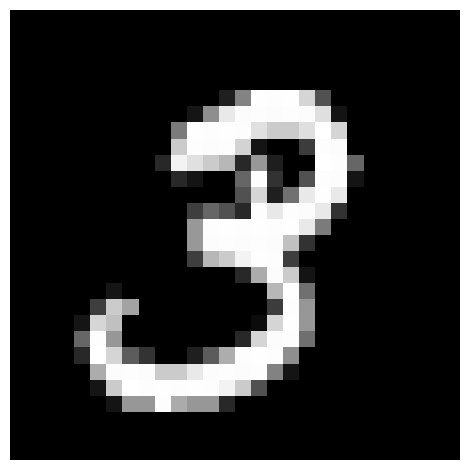

Target class: 3


In [12]:
# One can use matplotlib package to show the first training sample

import matplotlib.pyplot as plt

# dataset[i] is a shortcut for dataset.__getitem__(i)
image, label = train_dataset[0]
plt.figure()
plt.axis('off')
# Permutation required to go from Pytorch format (C, H, W) to matplotlib format (H, W, C)
plt.imshow(image.permute(1, 2, 0), cmap="gray")
plt.tight_layout()
plt.show()
print(f"Target class: {label}")

## II - Architecture implementation

We will use a modified version of LeNet-5 architecture, which takes as input grayscaled images of size (1, 28, 28).
Documentation for [Layers and Losses](https://pytorch.org/docs/stable/nn.html)

In [13]:
from torch import nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=400, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=5)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x):
        out = torch.tanh(self.conv1(x))
        out = self.max_pool(out)
        out = torch.tanh(self.conv2(out))
        out = self.max_pool(out)
        out = out.reshape(out.size(0), -1) # flatten the representation (from 2D image to 1D vector)
        out = torch.tanh(self.fc1(out))
        out = torch.tanh(self.fc2(out))
        out = self.fc3(out)
        return out

**Question 2**: How many kernels are used in conv1 and conv2?

**Question 3**: What is the decision layer?

In [14]:
# Check if GPU available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiation of the model
net = LeNet().to(device=device)

from torchsummary import summary
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]              60
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                 [-1, 1024]         410,624
            Linear-6                   [-1, 84]          86,100
            Linear-7                    [-1, 5]             425
Total params: 499,625
Trainable params: 499,625
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 1.91
Estimated Total Size (MB): 1.98
----------------------------------------------------------------


**Question 4**: What is the meaning of the "-1" value in the output shape?

**Question 5**: Which layers are parametric?

In [15]:
print(list(net.conv1.named_parameters()))

[('weight', Parameter containing:
tensor([[[[ 0.1470, -0.2819, -0.0723],
          [ 0.1397, -0.1095,  0.2530],
          [ 0.1165, -0.0165,  0.3124]]],


        [[[ 0.2396,  0.1615,  0.2251],
          [-0.2259,  0.0406, -0.0988],
          [ 0.0806,  0.0127, -0.0019]]],


        [[[ 0.0012, -0.0970, -0.1125],
          [ 0.2799,  0.2754, -0.1335],
          [-0.0840, -0.1759, -0.1832]]],


        [[[ 0.1168, -0.1933, -0.3047],
          [ 0.1888, -0.1808,  0.0678],
          [ 0.1974, -0.1259, -0.0531]]],


        [[[ 0.0322,  0.0996,  0.1217],
          [-0.0124,  0.0167,  0.1242],
          [ 0.2516,  0.0950,  0.2244]]],


        [[[-0.1420, -0.0579,  0.2578],
          [ 0.2182, -0.3049, -0.2354],
          [ 0.1652, -0.1991, -0.2535]]]], requires_grad=True)), ('bias', Parameter containing:
tensor([ 0.2779,  0.2775, -0.1734, -0.1640,  0.0295, -0.0106],
       requires_grad=True))]


**Question 6**: How many tensors of weights are stored for the conv1 layer?

In [16]:
image, label = test_dataset[0]
image = image.to(device)

# inference (forward pass)
net.eval()
with torch.inference_mode():
    output = net(image.unsqueeze(0))
print(output, output.size())

output = torch.softmax(output, dim=1)
print(output, output.size())

tensor([[-0.1764,  0.0900, -0.1037, -0.0767, -0.0951]]) torch.Size([1, 5])
tensor([[0.1795, 0.2343, 0.1931, 0.1984, 0.1947]]) torch.Size([1, 5])


**Question 7**: What is the goal of the softmax function?

**Question 8**: What is the meaning of the obtained values?

**Question 9**: What would be the predicted class?

## III - Training

Training consists in iteratively training on the training set and evaluating on the validation set to see the evolution of the performance on unseen data. One must define appropriate function for training and evaluation. The main difference lies in the computation of loss, gradients and backpropagation, which is only performed at training time.

In [17]:
import numpy as np
from tqdm import tqdm

# Training hyperparameters
num_epochs = 25
batch_size = 1000
learning_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

# Loss
loss_fn = torch.nn.CrossEntropyLoss()

# A dataloader is an iterator over the dataset. It is useful to perform an epoch.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
# function to compute Top-1 accuracy metric
def compute_top1_acc(prediction, ground_truth):
    # prediction (B, N), ground_truth (B)
    best_prediction = torch.argmax(prediction, dim=1)
    return torch.mean(torch.eq(best_prediction, ground_truth), dtype=torch.float)

In [19]:
# function to perform batch-gradient descent
def train_batch(x, y, net, optimizer, loss_function):
    x, y = x.to(net.device), y.to(net.device)  # put model weights and inputs on the same device (CPU/GPU)
    optimizer.zero_grad()  # zero the gradient buffers
    output = net(x)  # inference (forward-pass)
    loss = loss_function(output, y) # compute loss
    loss.backward()  # compute gradients (backward-pass)
    optimizer.step()  # apply gradients (backward-pass)
    top1_acc = compute_top1_acc(output, y) # compute metric
    return loss.item(), top1_acc.item()

In [20]:
# function to train over all the training samples through batch gradient descent
def train_epoch(dataloader, net, optimizer, loss_fn):
    epoch_loss = list()
    epoch_top1_acc = list()
    net.train()
    progress_bar = tqdm(dataloader)
    for x, y in progress_bar:
        progress_bar.set_description("Training")
        batch_loss, batch_top1_acc = train_batch(x, y, net, optimizer, loss_fn)
        epoch_loss.append(batch_loss)
        epoch_top1_acc.append(batch_top1_acc)
        current_loss = np.mean(epoch_loss)
        current_top1_acc = 100 * np.mean(epoch_top1_acc)
    return current_loss, current_top1_acc

In [21]:
# function to evaluate performance over a batch (forward pass only)
def eval_batch(x, y, net):
    x, y = x.to(net.device), y.to(net.device)
    output = net(x)
    top1_acc = compute_top1_acc(output, y)
    return top1_acc.item()

In [22]:
# function to evaluate performance over a whole set (forward pass only)
def eval(dataloader, net):
    top1_acc = list()
    net.eval()
    with torch.inference_mode(): # prevent tracking gradient-related operation
        for x, y in dataloader:
            batch_top1_acc = eval_batch(x, y, net)
            top1_acc.append(batch_top1_acc)
    return 100 * np.mean(top1_acc)

In [23]:
val_acc = eval(val_loader, net)
print(f"top-1 accuracy: {val_acc:.2f}%")

top-1 accuracy: 21.29%


**Question 10**: Explain the obtained result. Was it expected?

In [24]:
# Weights are constantly updated through the training process
# At some point, performance on the validation set may decrease due to over-fitting
# That is why it is important to regularly evaluate the model on the validation set and to save the associated weights
# If it is computationally affordable, this can be done between each epoch

metrics = {
    "train_loss": list(),
    "train_accuracy": list(),
    "val_accuracy": list()
}
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(train_loader, net, optimizer, loss_fn)
    metrics["train_loss"].append(train_loss)
    metrics["train_accuracy"].append(train_acc)
    print(f"Train epoch {epoch+1}: loss: {train_loss:.4f} ; top-1 accuracy: {train_acc:.2f}%")

    val_acc = eval(val_loader, net)
    if epoch == 0 or max(metrics["val_accuracy"]) < val_acc:
        torch.save(net.state_dict(), "best_model_weights.pth")
    metrics["val_accuracy"].append(val_acc)
    print(f"Eval epoch {epoch+1}: top-1 accuracy: {val_acc:.2f}%")


Training: 100%|██████████| 26/26 [00:01<00:00, 20.94it/s]


Train epoch 1: loss: 1.5763 ; top-1 accuracy: 39.06%
Eval epoch 1: top-1 accuracy: 61.88%


Training: 100%|██████████| 26/26 [00:01<00:00, 21.07it/s]


Train epoch 2: loss: 1.5018 ; top-1 accuracy: 68.98%
Eval epoch 2: top-1 accuracy: 75.96%


Training: 100%|██████████| 26/26 [00:01<00:00, 21.98it/s]


Train epoch 3: loss: 1.4062 ; top-1 accuracy: 77.53%
Eval epoch 3: top-1 accuracy: 83.96%


Training: 100%|██████████| 26/26 [00:01<00:00, 21.85it/s]


Train epoch 4: loss: 1.2746 ; top-1 accuracy: 81.98%
Eval epoch 4: top-1 accuracy: 86.09%


Training: 100%|██████████| 26/26 [00:01<00:00, 22.11it/s]


Train epoch 5: loss: 1.1115 ; top-1 accuracy: 83.77%
Eval epoch 5: top-1 accuracy: 87.86%


Training: 100%|██████████| 26/26 [00:01<00:00, 16.46it/s]


Train epoch 6: loss: 0.9421 ; top-1 accuracy: 85.76%
Eval epoch 6: top-1 accuracy: 89.96%


Training: 100%|██████████| 26/26 [00:01<00:00, 15.27it/s]


Train epoch 7: loss: 0.7863 ; top-1 accuracy: 88.48%
Eval epoch 7: top-1 accuracy: 92.14%


Training: 100%|██████████| 26/26 [00:01<00:00, 15.26it/s]


Train epoch 8: loss: 0.6522 ; top-1 accuracy: 90.54%
Eval epoch 8: top-1 accuracy: 93.01%


Training: 100%|██████████| 26/26 [00:01<00:00, 15.25it/s]


Train epoch 9: loss: 0.5413 ; top-1 accuracy: 92.04%
Eval epoch 9: top-1 accuracy: 93.61%


Training: 100%|██████████| 26/26 [00:01<00:00, 17.20it/s]


Train epoch 10: loss: 0.4549 ; top-1 accuracy: 92.86%
Eval epoch 10: top-1 accuracy: 94.36%


Training: 100%|██████████| 26/26 [00:01<00:00, 20.31it/s]


Train epoch 11: loss: 0.3884 ; top-1 accuracy: 93.59%
Eval epoch 11: top-1 accuracy: 94.86%


Training: 100%|██████████| 26/26 [00:01<00:00, 20.63it/s]


Train epoch 12: loss: 0.3395 ; top-1 accuracy: 93.91%
Eval epoch 12: top-1 accuracy: 95.23%


Training: 100%|██████████| 26/26 [00:01<00:00, 17.40it/s]


Train epoch 13: loss: 0.3009 ; top-1 accuracy: 94.26%
Eval epoch 13: top-1 accuracy: 95.72%


Training: 100%|██████████| 26/26 [00:01<00:00, 17.49it/s]


Train epoch 14: loss: 0.2718 ; top-1 accuracy: 94.53%
Eval epoch 14: top-1 accuracy: 95.81%


Training: 100%|██████████| 26/26 [00:01<00:00, 16.92it/s]


Train epoch 15: loss: 0.2496 ; top-1 accuracy: 94.70%
Eval epoch 15: top-1 accuracy: 95.97%


Training: 100%|██████████| 26/26 [00:01<00:00, 17.06it/s]


Train epoch 16: loss: 0.2312 ; top-1 accuracy: 94.93%
Eval epoch 16: top-1 accuracy: 96.09%


Training: 100%|██████████| 26/26 [00:01<00:00, 16.63it/s]


Train epoch 17: loss: 0.2162 ; top-1 accuracy: 95.08%
Eval epoch 17: top-1 accuracy: 96.24%


Training: 100%|██████████| 26/26 [00:01<00:00, 23.43it/s]


Train epoch 18: loss: 0.2037 ; top-1 accuracy: 95.24%
Eval epoch 18: top-1 accuracy: 96.42%


Training: 100%|██████████| 26/26 [00:01<00:00, 21.75it/s]


Train epoch 19: loss: 0.1935 ; top-1 accuracy: 95.33%
Eval epoch 19: top-1 accuracy: 96.49%


Training: 100%|██████████| 26/26 [00:01<00:00, 19.87it/s]


Train epoch 20: loss: 0.1842 ; top-1 accuracy: 95.48%
Eval epoch 20: top-1 accuracy: 96.66%


Training: 100%|██████████| 26/26 [00:01<00:00, 22.56it/s]


Train epoch 21: loss: 0.1758 ; top-1 accuracy: 95.62%
Eval epoch 21: top-1 accuracy: 96.77%


Training: 100%|██████████| 26/26 [00:01<00:00, 21.48it/s]


Train epoch 22: loss: 0.1684 ; top-1 accuracy: 95.74%
Eval epoch 22: top-1 accuracy: 96.86%


Training: 100%|██████████| 26/26 [00:01<00:00, 22.27it/s]


Train epoch 23: loss: 0.1619 ; top-1 accuracy: 95.87%
Eval epoch 23: top-1 accuracy: 96.92%


Training: 100%|██████████| 26/26 [00:01<00:00, 20.42it/s]


Train epoch 24: loss: 0.1567 ; top-1 accuracy: 95.91%
Eval epoch 24: top-1 accuracy: 96.97%


Training: 100%|██████████| 26/26 [00:01<00:00, 23.30it/s]


Train epoch 25: loss: 0.1509 ; top-1 accuracy: 96.08%
Eval epoch 25: top-1 accuracy: 97.02%


**Question 11**: How many back-propagations are performed per epoch? Why?

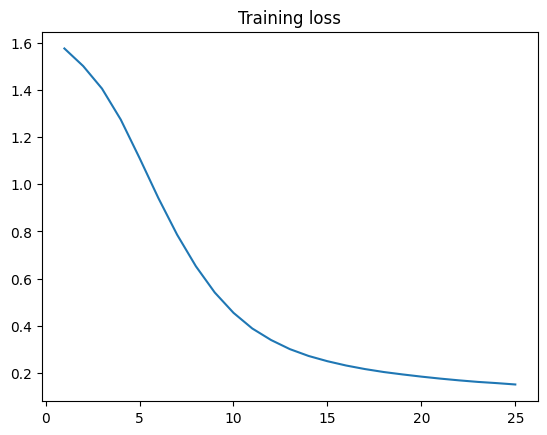

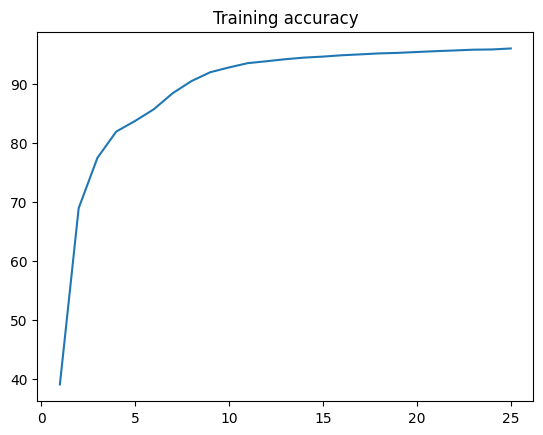

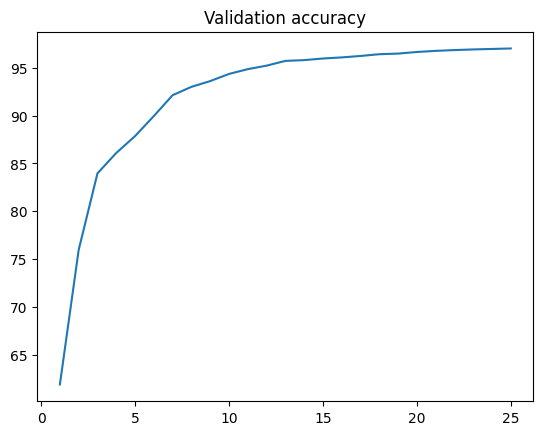

In [25]:
# Drawing training curves
def plot_curve(title, metric):
    plt.figure()
    plt.title(title)
    plt.plot(np.arange(len(metric))+1, metric)
    plt.show()

plot_curve("Training loss", metrics["train_loss"])
plot_curve("Training accuracy", metrics["train_accuracy"])
plot_curve("Validation accuracy", metrics["val_accuracy"])

In [26]:
# Retrieve the best weights
checkpoint = torch.load("best_model_weights.pth")
net.load_state_dict(checkpoint)

# Evaluate on the test set
test_acc = eval(test_loader, net)
print(f"top-1 accuracy: {test_acc:.2f}%")

/tmp/ipykernel_4730/2346019943.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_weights.pth")


top-1 accuracy: 96.21%


## Answers to questions

**Question 1**: Why do we add a validation split, in addition to the test set?

Performance is evaluated on the validation set through the epochs during training.  
We select the weights that lead to the best results on the validation set. There is a selection bias; so we evaluate on a test set to have more relevant results on unseen data.

**Question 2**: How many kernels are used in conv1 and conv2?  

Number of kernels = number of output feature maps  
Conv1: 6 kernels  
conv2: 16 kernels  


**Question 3**: What is the decision layer?  

The decision layer is the last one = the layer that generate one score per class (fc3).  


**Question 4**: What is the meaning of the "-1" value in the output shape?  

The first value corresponds to the mini-batch size (not known in advance so -1 with a joker meaning)


**Question 5**: Which layers are parametric?  

Convolutions and fully-connected layers are the parametrics ones.  
No parameter is required for a pooling or activation layer.

**Question 6**: How many tensors of weights are stored for the conv1 layer?  

Two tensors : one for the weights, one for the biases  

**Question 7**: What is the goal of the softmax function?  

Normalizing the score values to have a probability distribution.  


**Question 8**: What is the meaning of the obtained values?  

Each value is a probability of a class (from digit 0 to digit 4).  


**Question 9**: What would be the predicted class?  

The predicted class is the one with highest probability (depends on the execution)  


**Question 10**: Explain the obtained result. Was it expected?  
Regarding question 8: all values must be close (near 20%).   
Indeed, the model predicts random scores before training and there is 5 classes (1/5=20%)


**Question 11**: How many back-propagations are performed per epoch? Why?

There are 26 steps in the training progress bars, which correspond to the number of back propagations per epoch.  
Indeed, there are 25,518 training samples, and the mini-batch size is 1,000. So 26 mini-batch gradient descents are required to perform an epoch.

# Your turn

## Exercise on transfer learning and fine-tuning

We will use the pre-trained model weights on digit 0 to 4, to initialize a new model which will perform classification over all the 10 digits.

- Generate new datasets with all the digits
- Adapt the architecture
- Compare performance when training
    - from scratch
    - from pre-trained weights (fine-tuning)
    - from pre-trained weights with conv layers frozen (transfer learning)

One can freeze a layer by switching to False the "requires_grad" attribute for all its parameters:
```param.requires_grad = False```

In [27]:
labels = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9) # Only modif HERE
train_dataset_all = MNISTDataset(set_name="train", labels=labels)
val_dataset_all = MNISTDataset(set_name="val", labels=labels)
test_dataset_all = MNISTDataset(set_name="test", labels=labels)

train_loader_all = DataLoader(train_dataset_all, batch_size=batch_size, shuffle=True)
val_loader_all = DataLoader(val_dataset_all, batch_size=batch_size, shuffle=False)
test_loader_all = DataLoader(test_dataset_all, batch_size=batch_size, shuffle=False)

class LeNet2(nn.Module):
    def __init__(self):
        super(LeNet2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=400, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=84)
        self.fc3_new = nn.Linear(in_features=84, out_features=10)  # Only modif HERE (must modify name for load_state_dict)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, x):
        out = torch.tanh(self.conv1(x))
        out = self.max_pool(out)
        out = torch.tanh(self.conv2(out))
        out = self.max_pool(out)
        out = out.reshape(out.size(0), -1)
        out = torch.tanh(self.fc1(out))
        out = torch.tanh(self.fc2(out))
        out = self.fc3_new(out) # Only modif HERE
        return out

Training: 100%|██████████| 50/50 [00:02<00:00, 19.49it/s]


Train epoch 1: loss: 2.2860 ; top-1 accuracy: 16.37%
Eval epoch 1: top-1 accuracy: 28.06%


Training: 100%|██████████| 50/50 [00:02<00:00, 24.36it/s]


Train epoch 2: loss: 2.2444 ; top-1 accuracy: 38.46%
Eval epoch 2: top-1 accuracy: 50.75%


Training: 100%|██████████| 50/50 [00:02<00:00, 20.44it/s]


Train epoch 3: loss: 2.1897 ; top-1 accuracy: 55.46%
Eval epoch 3: top-1 accuracy: 62.35%


Training: 100%|██████████| 50/50 [00:02<00:00, 19.15it/s]


Train epoch 4: loss: 2.1028 ; top-1 accuracy: 63.01%
Eval epoch 4: top-1 accuracy: 65.59%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.93it/s]


Train epoch 5: loss: 1.9591 ; top-1 accuracy: 64.54%
Eval epoch 5: top-1 accuracy: 65.95%


Training: 100%|██████████| 50/50 [00:02<00:00, 19.23it/s]


Train epoch 6: loss: 1.7468 ; top-1 accuracy: 64.90%
Eval epoch 6: top-1 accuracy: 67.49%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.84it/s]


Train epoch 7: loss: 1.5013 ; top-1 accuracy: 67.34%
Eval epoch 7: top-1 accuracy: 70.30%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.93it/s]


Train epoch 8: loss: 1.2849 ; top-1 accuracy: 70.32%
Eval epoch 8: top-1 accuracy: 73.84%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.10it/s]


Train epoch 9: loss: 1.1159 ; top-1 accuracy: 73.16%
Eval epoch 9: top-1 accuracy: 76.62%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.62it/s]


Train epoch 10: loss: 0.9883 ; top-1 accuracy: 75.45%
Eval epoch 10: top-1 accuracy: 79.00%


Training: 100%|██████████| 50/50 [00:02<00:00, 17.60it/s]


Train epoch 11: loss: 0.8905 ; top-1 accuracy: 77.49%
Eval epoch 11: top-1 accuracy: 80.81%


Training: 100%|██████████| 50/50 [00:02<00:00, 16.99it/s]


Train epoch 12: loss: 0.8137 ; top-1 accuracy: 79.30%
Eval epoch 12: top-1 accuracy: 82.42%


Training: 100%|██████████| 50/50 [00:02<00:00, 16.85it/s]


Train epoch 13: loss: 0.7515 ; top-1 accuracy: 80.71%
Eval epoch 13: top-1 accuracy: 83.73%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.08it/s]


Train epoch 14: loss: 0.6994 ; top-1 accuracy: 81.97%
Eval epoch 14: top-1 accuracy: 84.98%


Training: 100%|██████████| 50/50 [00:02<00:00, 17.90it/s]


Train epoch 15: loss: 0.6549 ; top-1 accuracy: 83.15%
Eval epoch 15: top-1 accuracy: 85.98%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.84it/s]


Train epoch 16: loss: 0.6156 ; top-1 accuracy: 84.06%
Eval epoch 16: top-1 accuracy: 87.03%


Training: 100%|██████████| 50/50 [00:02<00:00, 17.65it/s]


Train epoch 17: loss: 0.5807 ; top-1 accuracy: 84.90%
Eval epoch 17: top-1 accuracy: 87.83%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.50it/s]


Train epoch 18: loss: 0.5497 ; top-1 accuracy: 85.77%
Eval epoch 18: top-1 accuracy: 88.57%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.74it/s]


Train epoch 19: loss: 0.5212 ; top-1 accuracy: 86.53%
Eval epoch 19: top-1 accuracy: 89.19%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.77it/s]


Train epoch 20: loss: 0.4956 ; top-1 accuracy: 87.19%
Eval epoch 20: top-1 accuracy: 89.84%


Training: 100%|██████████| 50/50 [00:02<00:00, 17.48it/s]


Train epoch 21: loss: 0.4721 ; top-1 accuracy: 87.82%
Eval epoch 21: top-1 accuracy: 90.15%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.21it/s]


Train epoch 22: loss: 0.4506 ; top-1 accuracy: 88.40%
Eval epoch 22: top-1 accuracy: 90.64%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.38it/s]


Train epoch 23: loss: 0.4303 ; top-1 accuracy: 88.83%
Eval epoch 23: top-1 accuracy: 90.89%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.10it/s]


Train epoch 24: loss: 0.4122 ; top-1 accuracy: 89.29%
Eval epoch 24: top-1 accuracy: 91.24%


Training: 100%|██████████| 50/50 [00:02<00:00, 20.03it/s]


Train epoch 25: loss: 0.3955 ; top-1 accuracy: 89.76%
Eval epoch 25: top-1 accuracy: 91.72%


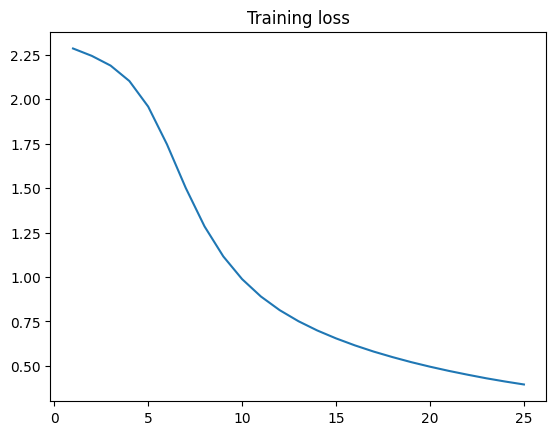

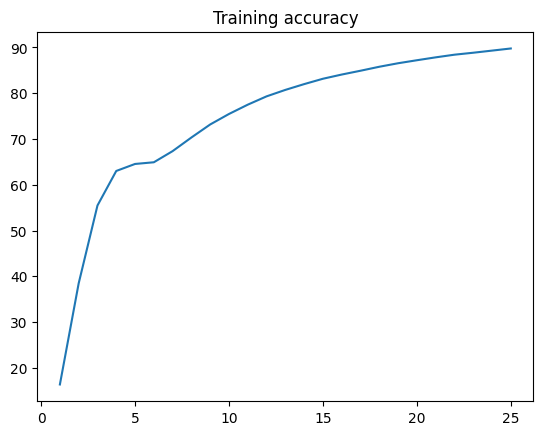

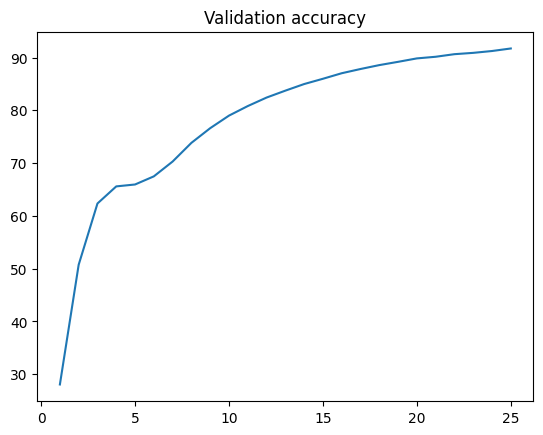

top-1 accuracy: 91.48%


/tmp/ipykernel_4730/2889421472.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_weights_scratch.pth")


In [28]:
# FROM SCRATCH
net_scratch = LeNet2().to(device)
optimizer = torch.optim.SGD(net_scratch.parameters(), lr=learning_rate)
metrics = {
    "train_loss": list(),
    "train_accuracy": list(),
    "val_accuracy": list()
}
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(train_loader_all, net_scratch, optimizer, loss_fn)
    metrics["train_loss"].append(train_loss)
    metrics["train_accuracy"].append(train_acc)
    print(f"Train epoch {epoch+1}: loss: {train_loss:.4f} ; top-1 accuracy: {train_acc:.2f}%")

    val_acc = eval(val_loader_all, net_scratch)
    if epoch == 0 or max(metrics["val_accuracy"]) < val_acc:
        torch.save(net_scratch.state_dict(), "best_model_weights_scratch.pth")
    metrics["val_accuracy"].append(val_acc)
    print(f"Eval epoch {epoch+1}: top-1 accuracy: {val_acc:.2f}%")

plot_curve("Training loss", metrics["train_loss"])
plot_curve("Training accuracy", metrics["train_accuracy"])
plot_curve("Validation accuracy", metrics["val_accuracy"])
checkpoint = torch.load("best_model_weights_scratch.pth")
net_scratch.load_state_dict(checkpoint)
test_acc = eval(test_loader, net_scratch)
print(f"top-1 accuracy: {test_acc:.2f}%")

/tmp/ipykernel_4730/3958351834.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights5digits = torch.load("best_model_weights.pth")
Training: 100%|██████████| 50/50 [00

Train epoch 1: loss: 1.9660 ; top-1 accuracy: 43.01%
Eval epoch 1: top-1 accuracy: 63.62%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.71it/s]


Train epoch 2: loss: 1.4863 ; top-1 accuracy: 66.13%
Eval epoch 2: top-1 accuracy: 71.10%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.71it/s]


Train epoch 3: loss: 1.1983 ; top-1 accuracy: 71.84%
Eval epoch 3: top-1 accuracy: 76.70%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.20it/s]


Train epoch 4: loss: 1.0051 ; top-1 accuracy: 76.75%
Eval epoch 4: top-1 accuracy: 81.13%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.65it/s]


Train epoch 5: loss: 0.8648 ; top-1 accuracy: 80.46%
Eval epoch 5: top-1 accuracy: 84.43%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.73it/s]


Train epoch 6: loss: 0.7592 ; top-1 accuracy: 82.90%
Eval epoch 6: top-1 accuracy: 86.02%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.53it/s]


Train epoch 7: loss: 0.6774 ; top-1 accuracy: 84.73%
Eval epoch 7: top-1 accuracy: 87.71%


Training: 100%|██████████| 50/50 [00:02<00:00, 19.09it/s]


Train epoch 8: loss: 0.6128 ; top-1 accuracy: 85.97%
Eval epoch 8: top-1 accuracy: 88.62%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.91it/s]


Train epoch 9: loss: 0.5605 ; top-1 accuracy: 87.07%
Eval epoch 9: top-1 accuracy: 89.36%


Training: 100%|██████████| 50/50 [00:02<00:00, 19.08it/s]


Train epoch 10: loss: 0.5172 ; top-1 accuracy: 87.89%
Eval epoch 10: top-1 accuracy: 90.11%


Training: 100%|██████████| 50/50 [00:02<00:00, 19.37it/s]


Train epoch 11: loss: 0.4812 ; top-1 accuracy: 88.52%
Eval epoch 11: top-1 accuracy: 90.65%


Training: 100%|██████████| 50/50 [00:02<00:00, 17.55it/s]


Train epoch 12: loss: 0.4503 ; top-1 accuracy: 89.11%
Eval epoch 12: top-1 accuracy: 91.12%


Training: 100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


Train epoch 13: loss: 0.4239 ; top-1 accuracy: 89.69%
Eval epoch 13: top-1 accuracy: 91.67%


Training: 100%|██████████| 50/50 [00:02<00:00, 17.61it/s]


Train epoch 14: loss: 0.4010 ; top-1 accuracy: 90.17%
Eval epoch 14: top-1 accuracy: 92.04%


Training: 100%|██████████| 50/50 [00:02<00:00, 19.47it/s]


Train epoch 15: loss: 0.3814 ; top-1 accuracy: 90.61%
Eval epoch 15: top-1 accuracy: 92.41%


Training: 100%|██████████| 50/50 [00:02<00:00, 19.09it/s]


Train epoch 16: loss: 0.3639 ; top-1 accuracy: 90.92%
Eval epoch 16: top-1 accuracy: 92.62%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.38it/s]


Train epoch 17: loss: 0.3487 ; top-1 accuracy: 91.26%
Eval epoch 17: top-1 accuracy: 92.89%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.00it/s]


Train epoch 18: loss: 0.3348 ; top-1 accuracy: 91.51%
Eval epoch 18: top-1 accuracy: 93.12%


Training: 100%|██████████| 50/50 [00:02<00:00, 17.97it/s]


Train epoch 19: loss: 0.3222 ; top-1 accuracy: 91.78%
Eval epoch 19: top-1 accuracy: 93.28%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.23it/s]


Train epoch 20: loss: 0.3111 ; top-1 accuracy: 91.97%
Eval epoch 20: top-1 accuracy: 93.50%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.36it/s]


Train epoch 21: loss: 0.3010 ; top-1 accuracy: 92.17%
Eval epoch 21: top-1 accuracy: 93.67%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.86it/s]


Train epoch 22: loss: 0.2916 ; top-1 accuracy: 92.41%
Eval epoch 22: top-1 accuracy: 93.78%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.82it/s]


Train epoch 23: loss: 0.2831 ; top-1 accuracy: 92.58%
Eval epoch 23: top-1 accuracy: 93.81%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.78it/s]


Train epoch 24: loss: 0.2754 ; top-1 accuracy: 92.75%
Eval epoch 24: top-1 accuracy: 93.88%


Training: 100%|██████████| 50/50 [00:02<00:00, 18.88it/s]


Train epoch 25: loss: 0.2680 ; top-1 accuracy: 92.90%
Eval epoch 25: top-1 accuracy: 94.08%


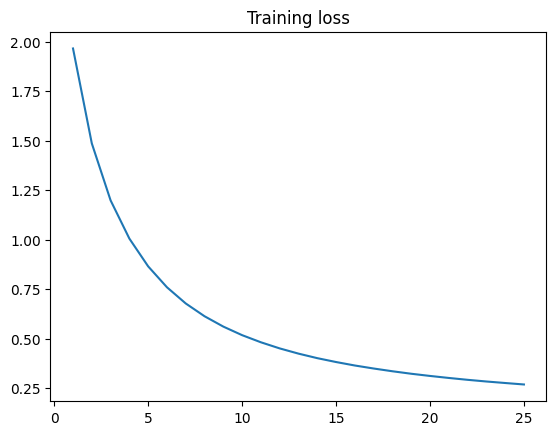

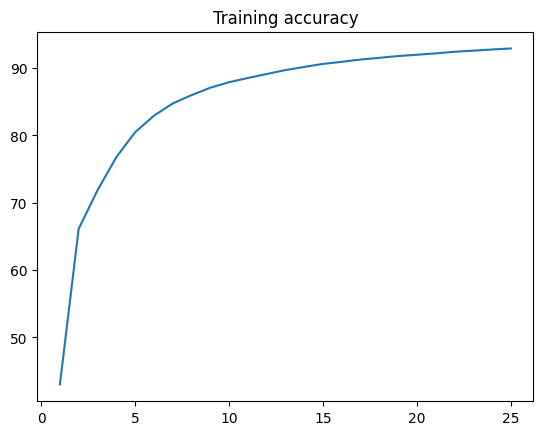

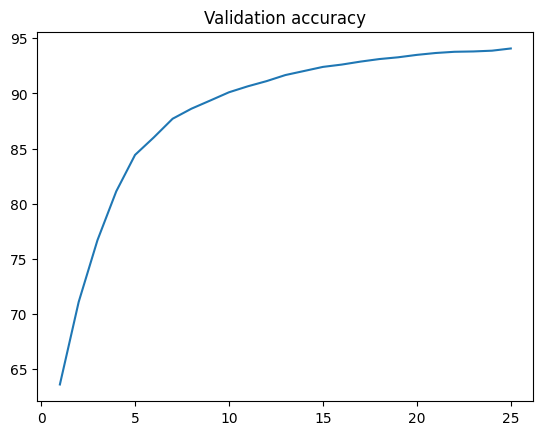

/tmp/ipykernel_4730/3958351834.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_weights_finetuning.pth")


top-1 accuracy: 94.52%


In [29]:
# FINE-TUNING
net_finetuning = LeNet2().to(device)
weights5digits = torch.load("best_model_weights.pth")
net_finetuning.load_state_dict(weights5digits, strict=False)

optimizer = torch.optim.SGD(net_finetuning.parameters(), lr=learning_rate)

metrics = {
    "train_loss": list(),
    "train_accuracy": list(),
    "val_accuracy": list()
}
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(train_loader_all, net_finetuning, optimizer, loss_fn)
    metrics["train_loss"].append(train_loss)
    metrics["train_accuracy"].append(train_acc)
    print(f"Train epoch {epoch+1}: loss: {train_loss:.4f} ; top-1 accuracy: {train_acc:.2f}%")

    val_acc = eval(val_loader_all, net_finetuning)
    if epoch == 0 or max(metrics["val_accuracy"]) < val_acc:
        torch.save(net_finetuning.state_dict(), "best_model_weights_finetuning.pth")
    metrics["val_accuracy"].append(val_acc)
    print(f"Eval epoch {epoch+1}: top-1 accuracy: {val_acc:.2f}%")

plot_curve("Training loss", metrics["train_loss"])
plot_curve("Training accuracy", metrics["train_accuracy"])
plot_curve("Validation accuracy", metrics["val_accuracy"])
checkpoint = torch.load("best_model_weights_finetuning.pth")
net_finetuning.load_state_dict(checkpoint)
test_acc = eval(test_loader, net_finetuning)
print(f"top-1 accuracy: {test_acc:.2f}%")

/tmp/ipykernel_4730/1496020607.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights5digits = torch.load("best_model_weights.pth")
Training: 100%|██████████| 50/50 [00

Train epoch 1: loss: 2.0168 ; top-1 accuracy: 39.42%
Eval epoch 1: top-1 accuracy: 60.03%


Training: 100%|██████████| 50/50 [00:01<00:00, 32.45it/s]


Train epoch 2: loss: 1.5294 ; top-1 accuracy: 66.40%
Eval epoch 2: top-1 accuracy: 72.10%


Training: 100%|██████████| 50/50 [00:01<00:00, 31.81it/s]


Train epoch 3: loss: 1.2581 ; top-1 accuracy: 71.88%
Eval epoch 3: top-1 accuracy: 75.88%


Training: 100%|██████████| 50/50 [00:01<00:00, 31.27it/s]


Train epoch 4: loss: 1.0829 ; top-1 accuracy: 75.28%
Eval epoch 4: top-1 accuracy: 79.10%


Training: 100%|██████████| 50/50 [00:01<00:00, 30.85it/s]


Train epoch 5: loss: 0.9539 ; top-1 accuracy: 78.55%
Eval epoch 5: top-1 accuracy: 82.16%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.66it/s]


Train epoch 6: loss: 0.8538 ; top-1 accuracy: 81.17%
Eval epoch 6: top-1 accuracy: 84.19%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.66it/s]


Train epoch 7: loss: 0.7741 ; top-1 accuracy: 82.77%
Eval epoch 7: top-1 accuracy: 85.83%


Training: 100%|██████████| 50/50 [00:01<00:00, 31.68it/s]


Train epoch 8: loss: 0.7098 ; top-1 accuracy: 84.14%
Eval epoch 8: top-1 accuracy: 86.88%


Training: 100%|██████████| 50/50 [00:01<00:00, 30.24it/s]


Train epoch 9: loss: 0.6572 ; top-1 accuracy: 85.10%
Eval epoch 9: top-1 accuracy: 87.82%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.04it/s]


Train epoch 10: loss: 0.6133 ; top-1 accuracy: 85.91%
Eval epoch 10: top-1 accuracy: 88.36%


Training: 100%|██████████| 50/50 [00:01<00:00, 34.06it/s]


Train epoch 11: loss: 0.5764 ; top-1 accuracy: 86.56%
Eval epoch 11: top-1 accuracy: 89.02%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.49it/s]


Train epoch 12: loss: 0.5450 ; top-1 accuracy: 87.05%
Eval epoch 12: top-1 accuracy: 89.52%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.62it/s]


Train epoch 13: loss: 0.5179 ; top-1 accuracy: 87.57%
Eval epoch 13: top-1 accuracy: 89.99%


Training: 100%|██████████| 50/50 [00:01<00:00, 32.38it/s]


Train epoch 14: loss: 0.4943 ; top-1 accuracy: 87.99%
Eval epoch 14: top-1 accuracy: 90.29%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.28it/s]


Train epoch 15: loss: 0.4736 ; top-1 accuracy: 88.36%
Eval epoch 15: top-1 accuracy: 90.50%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.91it/s]


Train epoch 16: loss: 0.4553 ; top-1 accuracy: 88.66%
Eval epoch 16: top-1 accuracy: 90.81%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.80it/s]


Train epoch 17: loss: 0.4390 ; top-1 accuracy: 88.89%
Eval epoch 17: top-1 accuracy: 91.05%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.69it/s]


Train epoch 18: loss: 0.4245 ; top-1 accuracy: 89.13%
Eval epoch 18: top-1 accuracy: 91.30%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.08it/s]


Train epoch 19: loss: 0.4114 ; top-1 accuracy: 89.34%
Eval epoch 19: top-1 accuracy: 91.40%


Training: 100%|██████████| 50/50 [00:01<00:00, 32.88it/s]


Train epoch 20: loss: 0.3996 ; top-1 accuracy: 89.60%
Eval epoch 20: top-1 accuracy: 91.61%


Training: 100%|██████████| 50/50 [00:01<00:00, 32.68it/s]


Train epoch 21: loss: 0.3889 ; top-1 accuracy: 89.80%
Eval epoch 21: top-1 accuracy: 91.80%


Training: 100%|██████████| 50/50 [00:01<00:00, 32.14it/s]


Train epoch 22: loss: 0.3791 ; top-1 accuracy: 89.98%
Eval epoch 22: top-1 accuracy: 91.96%


Training: 100%|██████████| 50/50 [00:01<00:00, 30.73it/s]


Train epoch 23: loss: 0.3702 ; top-1 accuracy: 90.16%
Eval epoch 23: top-1 accuracy: 92.09%


Training: 100%|██████████| 50/50 [00:01<00:00, 32.04it/s]


Train epoch 24: loss: 0.3620 ; top-1 accuracy: 90.33%
Eval epoch 24: top-1 accuracy: 92.21%


Training: 100%|██████████| 50/50 [00:01<00:00, 33.09it/s]


Train epoch 25: loss: 0.3544 ; top-1 accuracy: 90.46%
Eval epoch 25: top-1 accuracy: 92.28%


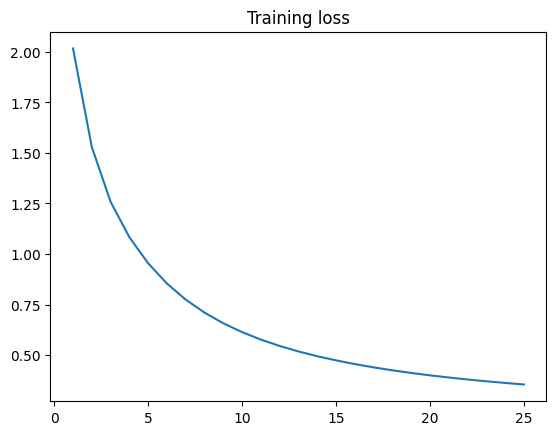

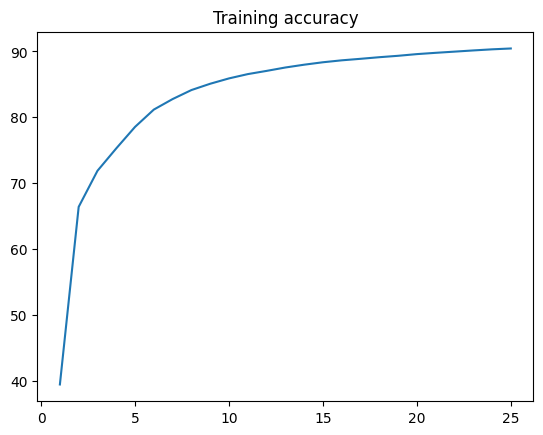

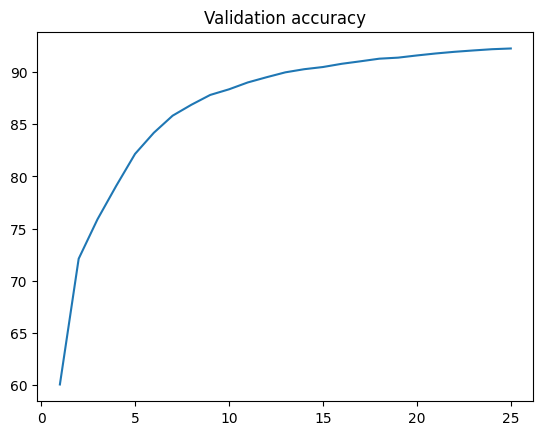

/tmp/ipykernel_4730/1496020607.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("best_model_weights_finetuning.pth")


top-1 accuracy: 92.27%


In [30]:
# TRANSFER LEARNING
net_transfer = LeNet2().to(device)
weights5digits = torch.load("best_model_weights.pth")
net_transfer.load_state_dict(weights5digits, strict=False)
for param in [net_transfer.conv1.weight, net_transfer.conv1.bias, net_transfer.conv2.weight, net_transfer.conv2.bias]:
    param.requires_grad = False


optimizer = torch.optim.SGD(net_transfer.parameters(), lr=learning_rate)

metrics = {
    "train_loss": list(),
    "train_accuracy": list(),
    "val_accuracy": list()
}
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(train_loader_all, net_transfer, optimizer, loss_fn)
    metrics["train_loss"].append(train_loss)
    metrics["train_accuracy"].append(train_acc)
    print(f"Train epoch {epoch+1}: loss: {train_loss:.4f} ; top-1 accuracy: {train_acc:.2f}%")

    val_acc = eval(val_loader_all, net_transfer)
    if epoch == 0 or max(metrics["val_accuracy"]) < val_acc:
        torch.save(net_transfer.state_dict(), "best_model_weights_finetuning.pth")
    metrics["val_accuracy"].append(val_acc)
    print(f"Eval epoch {epoch+1}: top-1 accuracy: {val_acc:.2f}%")

plot_curve("Training loss", metrics["train_loss"])
plot_curve("Training accuracy", metrics["train_accuracy"])
plot_curve("Validation accuracy", metrics["val_accuracy"])
checkpoint = torch.load("best_model_weights_finetuning.pth")
net_transfer.load_state_dict(checkpoint)
test_acc = eval(test_loader, net_transfer)
print(f"top-1 accuracy: {test_acc:.2f}%")

## Exercise on architecture

Improve the architecture to have better results

- Change the number of layers
- Change the kind of layers, the number of channels/neurons per layer
- Change the [Optimizer](https://pytorch.org/docs/stable/optim.html) / the learning rate
- Add regularization techniques (normalization, dropout)
- Change the activation functions (tanh, relu)